Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io
import sys
import copy

## ampis
root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)

from ampis import analyze, data_utils
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset

%matplotlib inline

# Loading Data
To save time, we can avoid calculating performances by loading in already saved performances



In [2]:
with open('Model_Performances/segmentation_data.json', 'r') as fp:
    data = json.load(fp)
list_average_p = data['P']
list_average_r = data['R']
num_trainings = data['num']
extension = data['e_list']

# Calculating Data
For evaluating the segmentation performance, we need to calculate the precision and recall for each image at each number of training images for every number of training iterations

In [2]:
list_average_p = []
list_average_r = []
extension = ['999', '1999', '2999', '3999', '4999', '5999', '6999', '7999', '8999', '9999', '10999', '11999', '12999', '13999', '14999']
num_trainings = 5
for t in range(num_trainings):
    list_average_p.append([])
    list_average_r.append([])
for t in range(num_trainings):
    EXPERIMENT_NUM = t
    list_average_p.append([])
    list_average_r.append([])
    for i in range(15):
        #Loading Ground Truth Labels
        satellites_gt_path = satellites_gt_path = Path(ocean_syn,'trainings', f'synthetic_validation_satellite_a1.0.json')  # path to training data
        for path in [satellites_gt_path]:
            assert path.is_file(), f'File not found : {path}'
        satellites_gt_dd = data_utils.get_ddicts('via2', satellites_gt_path, dataset_class='train')
        #Loading Prediction Labels
        satellites_path = Path('Model_Performances', f'Training_{EXPERIMENT_NUM + 1}_image', f'satellite-model_a1.{EXPERIMENT_NUM}_section_{extension[i]}.pickle')
        assert satellites_path.is_file()
        with open(satellites_path, 'rb') as f:
            satellites_pred = pickle.load(f)
        iset_satellites_gt = [InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd]
        iset_satellites_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in satellites_pred]
        #Creating Instance Set Objects
        iset_satellites_gt, iset_satellites_pred = analyze.align_instance_sets(iset_satellites_gt, iset_satellites_pred)
        #Re-ordering instance sets to be concurrent
        for gt, pred in zip(iset_satellites_gt, iset_satellites_pred):
            pred.HFW = gt.HFW
            pred.HFW_units = gt.HFW_units
            print(f'gt filename: {Path(gt.filepath).name}\t pred filename: {Path(pred.filepath).name}')
        #Creating Detection Scores
        dss_satellites = [analyze.det_seg_scores(gt, pred, size=gt.instances.image_size)
                         for gt, pred in zip(iset_satellites_gt, iset_satellites_pred)]
        labels = []
        counts = {'train': 0, 'validation': 0}
        for iset in iset_satellites_gt:
            counts[iset.dataset_class] += 1
            labels.append(iset.filepath.name)
        x=[*([1] * len(labels)), *([2] * len(labels))]
        # y values are the bar heights

        scores = [*[x['det_precision'] for x in dss_satellites],
             *[x['det_recall'] for x in dss_satellites]]
        labels = labels * 2
        print('x: ', x)
        print('y: ', [np.round(x, decimals=2) for x in scores])
        #print('labels: ', labels)
        '''fig, ax = plt.subplots(figsize=(6,3), dpi=150)
        sns.barplot(x=x, y=scores, hue=labels, ax=ax)
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('detection score')
        ax.set_xticklabels(['precision','recall'])
        print("Average Precision Score: ", str(sum([*[x['det_precision'] for x in dss_satellites]])/len([*[x['det_precision'] for x in dss_satellites]])))
        print("Average Precision Score: ", str(sum([*[x['det_recall'] for x in dss_satellites]])/len([*[x['det_recall'] for x in dss_satellites]])))
        '''
        #Analyzing Prediction Scores on a pixel level
        temp_p = []
        temp_r = []
        total_area = 1024*768
        for instance in range(len(iset_satellites_pred)):
            fp_area = 0
            fn_area = 0
            tp_area = 0
            iset_satellites_pred[instance].compute_rprops(keys=['area'])
            for i in dss_satellites[instance]['det_fp']:
                try: 
                    fp_area += int(iset_satellites_pred[instance].rprops['area'][i])
                except:
                    pass

            for i in dss_satellites[instance]['det_fn']:
                try: 
                    fn_area += int(iset_satellites_pred[instance].rprops['area'][i])
                except:
                    pass

            #print(dss_satellites[0]['seg_tp'])
            for i in dss_satellites[instance]['det_tp']:
                try: 
                    tp_area += int(iset_satellites_pred[instance].rprops['area'][i[1]])
                except:
                    pass
            print("Precision:", str(tp_area/(tp_area+fp_area)))
            print('Recall:', str(tp_area/(tp_area+fn_area)))
            temp_p.append(tp_area/(tp_area+fp_area))
            temp_r.append(tp_area/(tp_area+fn_area))
            print('---')
        list_average_p[t].append(temp_p)
        list_average_r[t].append(temp_r)
        counter = 0   
        for iset in iset_satellites_gt:
            gt = iset_satellites_gt[counter]
            pred = iset_satellites_pred[counter]
            iset_det, colormap = analyze.det_perf_iset(gt, pred)
            img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))
            #display_iset(img, iset=iset_det)
            counter += 1
        #list_average_p.append(copy.deepcopy(average_p))
        #list_average_r.append(copy.deepcopy(average_r))



gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.55, 0.43, 0.56, 0.61, 0.52, 0.55]
Precision: 0.5651678998292544
Recall: 0.6114532019704434
---
Precision: 0.4980463165920137
Recall: 0.55062690970393
---
Precision: 0.6251912889935256
Recall: 0.6003164914660337
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png


<ipython-input-2-57307c8ce147>:96: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))


x:  [1, 1, 1, 2, 2, 2]
y:  [0.6, 0.44, 0.58, 0.58, 0.52, 0.58]
Precision: 0.6249547046744776
Recall: 0.5936890418818129
---
Precision: 0.4744695969952289
Recall: 0.5421644820786452
---
Precision: 0.6731570179092045
Recall: 0.6425163983303518
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.61, 0.41, 0.6, 0.62, 0.49, 0.59]
Precision: 0.6742613920881322
Recall: 0.6578722364724563
---
Precision: 0.5065676756139349
Recall: 0.527724892908139
---
Precision: 0.690695067264574
Recall: 0.6408362804243811
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.58, 0.41, 0.64, 0.58, 0.51, 0.65]
Precision: 0.6445105392473813
Recall: 0.6116838487972509
---
Precision: 0.4932717000

Precision: 0.7317864986154874
Recall: 0.6823969370492388
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.71, 0.5, 0.66, 0.65, 0.52, 0.66]
Precision: 0.790079365079365
Recall: 0.6875
---
Precision: 0.5986499289436286
Recall: 0.5805673595957276
---
Precision: 0.7612427593470248
Recall: 0.6984249685959996
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.71, 0.53, 0.66, 0.7, 0.57, 0.66]
Precision: 0.7760702524698134
Recall: 0.7397116949546617
---
Precision: 0.6288730778058297
Recall: 0.6271457999542229
---
Precision: 0.7636005902606985
Recall: 0.670293609671848
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred fil

Precision: 0.7286458887352409
Recall: 0.6876129291306966
---
Precision: 0.5766489308302379
Recall: 0.5767647354152023
---
Precision: 0.7362867279177658
Recall: 0.6844241501775749
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.69, 0.55, 0.67, 0.68, 0.6, 0.69]
Precision: 0.6904985888993415
Recall: 0.7147030185004869
---
Precision: 0.6198058984264582
Recall: 0.6311042885925358
---
Precision: 0.7457429646890124
Recall: 0.6899668325041459
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.69, 0.51, 0.69, 0.64, 0.56, 0.67]
Precision: 0.7314772727272727
Recall: 0.6732559355715929
---
Precision: 0.5713629262016359
Recall: 0.5976735243222457
---
Precision: 0.7557887433

gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.59, 0.42, 0.59, 0.6, 0.52, 0.6]
Precision: 0.5423213380638622
Recall: 0.6430288461538461
---
Precision: 0.4388472167390446
Recall: 0.5763766462719071
---
Precision: 0.5845988922637128
Recall: 0.5980078589052362
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	 pred filename: particles1.png
x:  [1, 1, 1, 2, 2, 2]
y:  [0.63, 0.5, 0.69, 0.72, 0.6, 0.72]
Precision: 0.6169046977454414
Recall: 0.7117098445595855
---
Precision: 0.5894911199042974
Recall: 0.6350748488153068
---
Precision: 0.761618062088429
Recall: 0.741256180186779
---
gt filename: particles11.png	 pred filename: particles11.png
gt filename: particles10.png	 pred filename: particles10.png
gt filename: particles1.png	

# Saving Data
To save time later, calculated performances are saved to avoid calculating every time opened
This block of code only needs to be run if new segmentations are included, otherwise just skip

In [14]:
data = {'P': list_average_p, 'R': list_average_r, 'num': num_trainings, 'e_list':extension}
with open('Model_Performances/segmentation_data.json', 'w') as fp:
    json.dump(data, fp)

# Seperating Data
Takes calculated precision and recall scores and seperates them by image, by number of training images, and by number of training iterations so that graphs can be created

In [3]:
iteration_results_p = []
iteration_results_r = []
iteration_results_ave_p = []
iteration_results_ave_r = []
for i in range(num_trainings):
    iteration_results_p.append([[], [], []])
    iteration_results_r.append([[], [], []])
    iteration_results_ave_p.append([])
    iteration_results_ave_r.append([])
for i in range(num_trainings):
    for j in range(len(list_average_p[i])):
        iteration_results_p[i][0].append([(j+1)*1000 - 1, list_average_p[i][j][0]])
        iteration_results_p[i][1].append([(j+1)*1000 - 1, list_average_p[i][j][1]])
        iteration_results_p[i][2].append([(j+1)*1000 - 1, list_average_p[i][j][2]])
        iteration_results_r[i][0].append([(j+1)*1000 - 1, list_average_r[i][j][0]])
        iteration_results_r[i][1].append([(j+1)*1000 - 1, list_average_r[i][j][1]])
        iteration_results_r[i][2].append([(j+1)*1000 - 1, list_average_r[i][j][2]])
        iteration_results_ave_p[i].append([(j+1)*1000 - 1, (list_average_p[i][j][0] + list_average_p[i][j][1] + list_average_p[i][j][2])/3])
        iteration_results_ave_r[i].append([(j+1)*1000 - 1, (list_average_r[i][j][0] + list_average_r[i][j][1] + list_average_r[i][j][2])/3])


# Building a Dataframe for a heat map


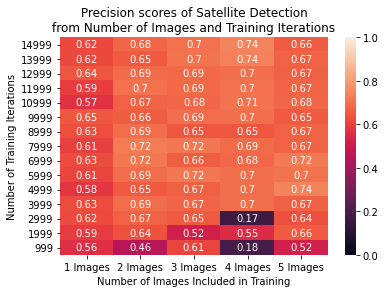

In [4]:
cols = ['14999', '13999', '12999', '11999', '10999', '9999', '8999', '7999', '6999', '5999', '4999', '3999', '2999', '1999', '999']
d = {}
count = -1
for i in iteration_results_ave_p:
    count += 1
    d[f'{count+1} Images'] = []
    for j in i:
        d[f'{count+1} Images'].append(j[1])
for i in d:
    d[i].reverse()
df = pd.DataFrame(d, index = cols)
p1 = sns.heatmap(df, vmin=0, vmax=1, annot=True)#, cmap="YlGn")
plt.xlabel('Number of Images Included in Training')
plt.ylabel('Number of Training Iterations')
plt.title('Precision scores of Satellite Detection\nfrom Number of Images and Training Iterations')
plt.show()
print('')

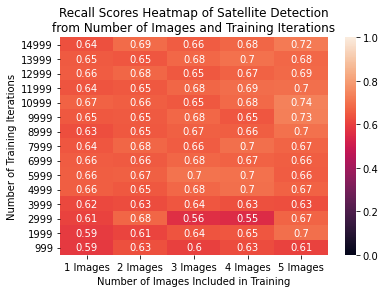

In [5]:
cols = ['14999', '13999', '12999', '11999', '10999', '9999', '8999', '7999', '6999', '5999', '4999', '3999', '2999', '1999', '999']
d = {}
count = -1
for i in iteration_results_ave_r:
    count += 1
    d[f'{count+1} Images'] = []
    for j in i:
        d[f'{count+1} Images'].append(j[1])
for i in d:
    d[i].reverse()
df = pd.DataFrame(d, index = cols)
p1 = sns.heatmap(df, vmin=0, vmax=1, annot=True)#, cmap="YlGn")
plt.xlabel('Number of Images Included in Training')
plt.ylabel('Number of Training Iterations')
plt.title('Recall Scores Heatmap of Satellite Detection\nfrom Number of Images and Training Iterations')
plt.show()
print('')

# Creating Graphs
For each combination a graph is created. This includes performance on each image for each number of training images and represent the performance over time based on iteations of training

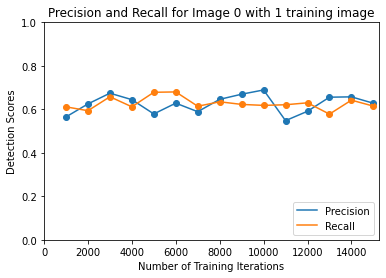

In [5]:
img_val_num = 0
num_img_included = 0 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

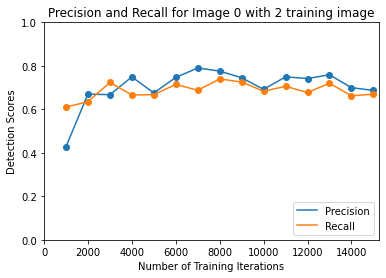

In [6]:
img_val_num = 0
num_img_included = 1 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

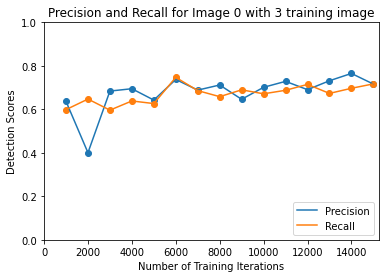

In [7]:
img_val_num = 0
num_img_included = 2 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

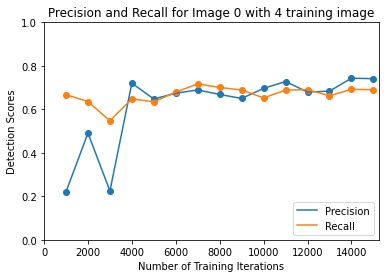

In [11]:
img_val_num = 0
num_img_included = 3 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

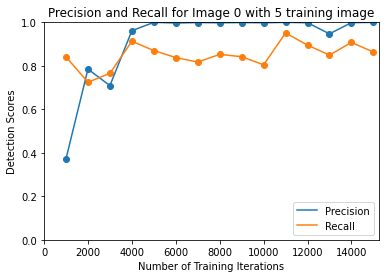

In [16]:
img_val_num = 0
num_img_included = 4 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

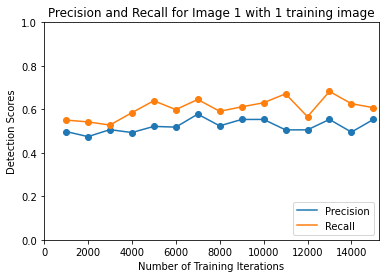

In [8]:
img_val_num = 1
num_img_included = 0 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1} training image')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

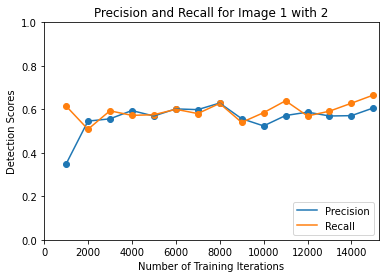

In [9]:
img_val_num = 1
num_img_included = 1 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

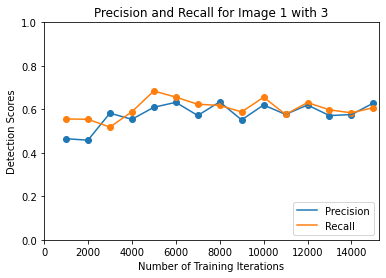

In [10]:
img_val_num = 1
num_img_included = 2 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

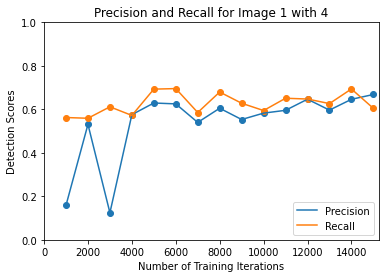

In [28]:
img_val_num = 1
num_img_included = 3 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

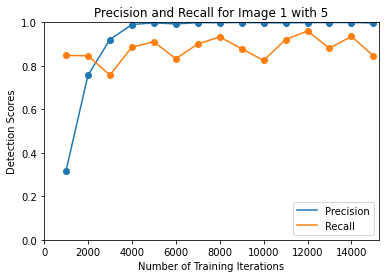

In [17]:
img_val_num = 1
num_img_included = 4 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

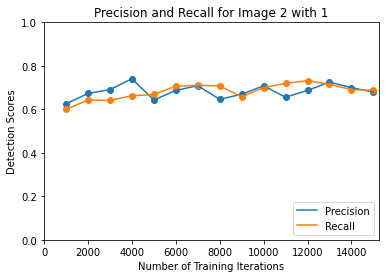

In [11]:
img_val_num = 2
num_img_included = 0 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

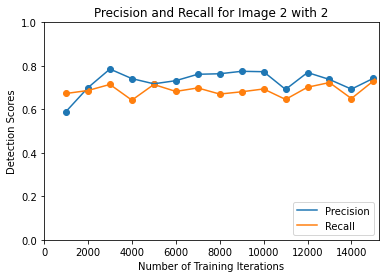

In [12]:
img_val_num = 2
num_img_included = 1 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

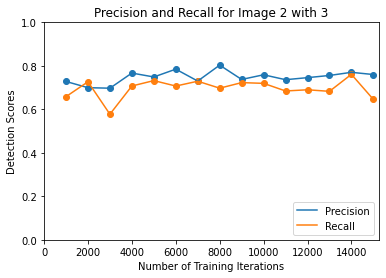

In [13]:
img_val_num = 2
num_img_included = 2 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

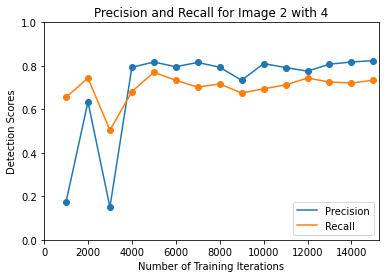

In [29]:
img_val_num = 2
num_img_included = 3 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

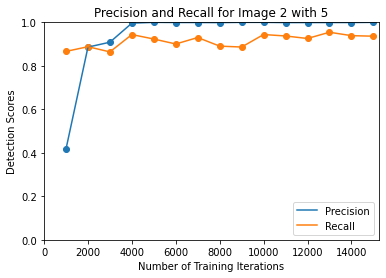

In [18]:
img_val_num = 2
num_img_included = 4 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Precision and Recall for Image {img_val_num} with {num_img_included + 1}')
xyz = np.array(iteration_results_p[num_img_included][img_val_num])
XYZ = np.array(iteration_results_r[num_img_included][img_val_num])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

# Average Score
Average Performance scores seperated by number of training images

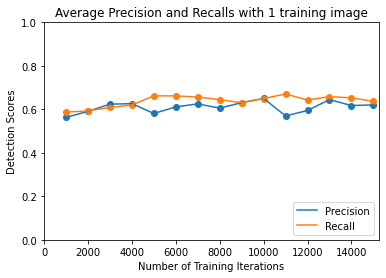

In [14]:
img_val_num = 2
num_img_included = 0 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Average Precision and Recalls with {num_img_included + 1} training image')
xyz = np.array(iteration_results_ave_p[num_img_included])
XYZ = np.array(iteration_results_ave_r[num_img_included])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

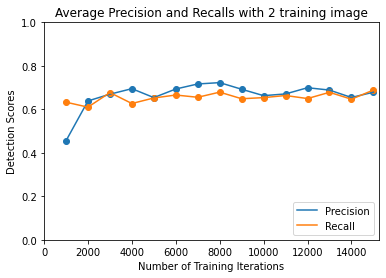

In [15]:
img_val_num = 2
num_img_included = 1 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Average Precision and Recalls with {num_img_included + 1} training image')
xyz = np.array(iteration_results_ave_p[num_img_included])
XYZ = np.array(iteration_results_ave_r[num_img_included])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

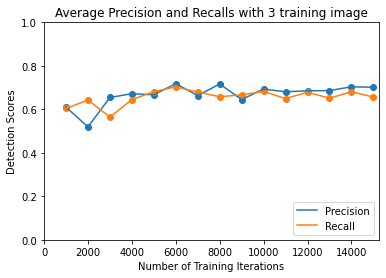

In [16]:
img_val_num = 2
num_img_included = 2 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Average Precision and Recalls with {num_img_included + 1} training image')
xyz = np.array(iteration_results_ave_p[num_img_included])
XYZ = np.array(iteration_results_ave_r[num_img_included])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

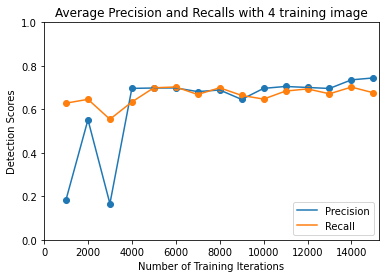

In [30]:
img_val_num = 2
num_img_included = 3 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Average Precision and Recalls with {num_img_included + 1} training image')
xyz = np.array(iteration_results_ave_p[num_img_included])
XYZ = np.array(iteration_results_ave_r[num_img_included])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

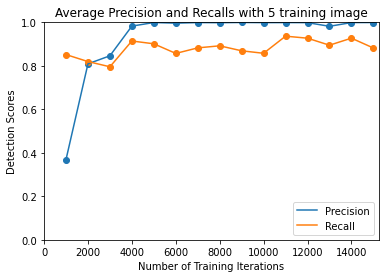

In [19]:
img_val_num = 2
num_img_included = 4 #this should be 1 less than it actually is due to it being in reference with index
plt.title(f'Average Precision and Recalls with {num_img_included + 1} training image')
xyz = np.array(iteration_results_ave_p[num_img_included])
XYZ = np.array(iteration_results_ave_r[num_img_included])
plt.ylabel("Detection Scores")
plt.xlabel("Number of Training Iterations")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([0, 15250, 0.0, 1.0])
print('')

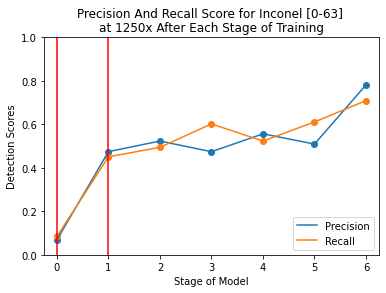

In [19]:
plt.title("Precision And Recall Score for Inconel [0-63] \nat 1250x After Each Stage of Training")
xyz = np.array(S03_1250_p)
XYZ = np.array(S03_1250_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(0, c='r')
plt.axvline(1, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')

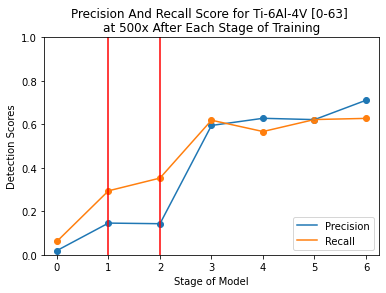

In [27]:
plt.title("Precision And Recall Score for Ti-6Al-4V [0-63] \nat 500x After Each Stage of Training")
xyz = np.array(S06_500_p)
XYZ = np.array(S06_500_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(1, c='r')
plt.axvline(2, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')


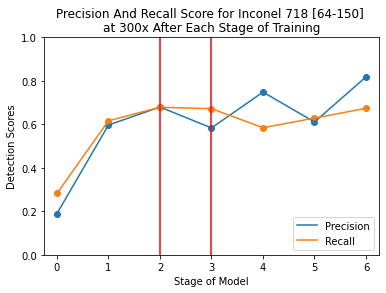

In [28]:
plt.title("Precision And Recall Score for Inconel 718 [64-150] \nat 300x After Each Stage of Training")
xyz = np.array(S02_300_p)
XYZ = np.array(S02_300_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(2, c='r')
plt.axvline(3, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')

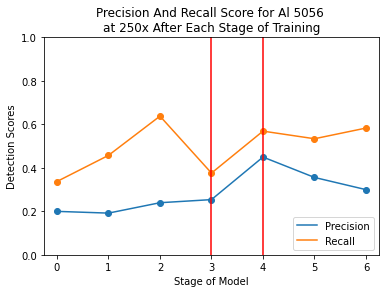

In [29]:
plt.title("Precision And Recall Score for Al 5056 \nat 250x After Each Stage of Training")
xyz = np.array(HP_250_p)
XYZ = np.array(HP_250_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(3, c='r')
plt.axvline(4, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')

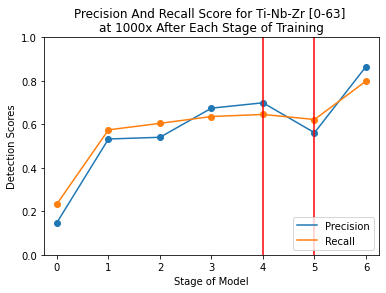

In [30]:
plt.title("Precision And Recall Score for Ti-Nb-Zr [0-63] \nat 1000x After Each Stage of Training")
xyz = np.array(S08_1000_p)
XYZ = np.array(S08_1000_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(4, c='r')
plt.axvline(5, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')

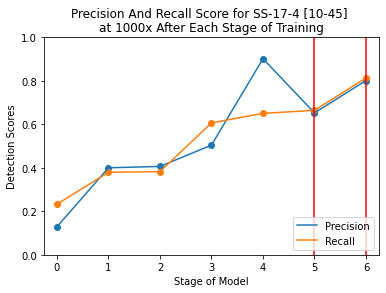

In [31]:
plt.title("Precision And Recall Score for SS-17-4 [10-45] \nat 1000x After Each Stage of Training")
xyz = np.array(S04_1000_p)
XYZ = np.array(S04_1000_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.axvline(5, c='r')
plt.axvline(6, c='r')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')

[0.14839258783652626, 0.019566355305549208, 0.12875831994491624, 0.06909037095501185, 0.18953248499177155, 0.19973909262211914]
[0.8657617832015441, 0.7107193563653573, 0.8015431748553273, 0.781253347616497, 0.8181818181818182, 0.2996729110912875]
[0.23399496126768854, 0.06183453321218052, 0.23276252263126132, 0.0845415585199493, 0.2820044144019865, 0.3370566653077864]
[0.7988624612202688, 0.6273629242819844, 0.8132627216209993, 0.7091598599766628, 0.6737680923727435, 0.5828802776171197]
Initial Model Precision: 0.12584653527598236
Final Model Precision: 0.712855398551972
Initial Model Recall: 0.20536577589014207
Final Model Recall: 0.7008827228482964
0.19973909262211914
0.19171135220517938
0.2395331604297888
0.25378672359459187
0.44953202422462835
0.3557541899441341
0.2996729110912875
Initial Model Precision: 0.11106802380675503
Final Model Precision: 0.7954918960441087
Initial Model Recall: 0.17902759800661322
Final Model Recall: 0.7244832118945318
[[0, 0.11106802380675503], [1, 0.42

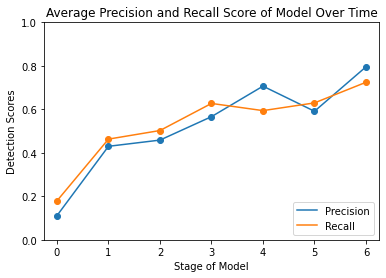

In [32]:
print(average_p[0])
print(average_p[-1])
print(average_r[0])
print(average_r[-1])
print("Initial Model Precision:", str(sum(average_p[0])/len(average_p[0])))
print("Final Model Precision:", str(sum(average_p[-1])/len(average_p[-1])))
print("Initial Model Recall:", str(sum(average_r[0])/len(average_r[0])))
print("Final Model Recall:", str(sum(average_r[-1])/len(average_r[-1])))
altered_average_p = []
altered_average_r = []
for i in average_p:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_p.append(temp)
for i in average_r:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_r.append(temp)
for i in range(len(altered_average_p)):
    print(altered_average_p[i].pop(-1))
for i in range(len(altered_average_r)):
    altered_average_r[i].pop(-1)
#print(altered_average_r)
print("Initial Model Precision:", str(sum(altered_average_p[0])/len(altered_average_p[0])))
print("Final Model Precision:", str(sum(altered_average_p[-1])/len(altered_average_p[-1])))
print("Initial Model Recall:", str(sum(altered_average_r[0])/len(altered_average_r[0])))
print("Final Model Recall:", str(sum(altered_average_r[-1])/len(altered_average_r[-1])))    
ave_p = []
ave_r = []
for i in range(len(altered_average_p)):
    ave_p.append([i, sum(altered_average_p[i])/len(altered_average_p[i])])
for i in range(len(altered_average_r)):
    ave_r.append([i, sum(altered_average_r[i])/len(altered_average_r[i])])
print(ave_p)
plt.title("Average Precision and Recall Score of Model Over Time")
xyz = np.array(ave_p)
XYZ = np.array(ave_r)
plt.ylabel("Detection Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1], label = 'Precision')
plt.scatter(XYZ[:,0], XYZ[:,1])
plt.plot(XYZ[:,0], XYZ[:,1], label = 'Recall')
plt.legend(loc="lower right")
plt.axis([-0.25, 6.25, 0.0, 1.0])
print('')


## Visualize segmentation results for powder

Segmentation results indicate how well each matched pair of masks agrees. True positives (included in both gt and pred masks) are shown in purple, false positive pixels (included in pred but not gt) are shown in blue, and false negative pixels (included in gt but not pred) are shown in red.

Detectron2 appears to smooth out masks, which can affect the display of discontinuous masks here. This can affect the display of the mask visualization, so we pass apply_correction=True to prevent this.

In [10]:
iset_seg, (colors, color_labels) = analyze.seg_perf_iset(gt, pred,)
#display_iset(img, iset=iset_seg, apply_correction=True)

## Visualize match results for satellites
The process above can be repeated exactl to analyze the satellite results.

In [11]:
# select instances for the same image
gt_s, pred_s = [(x, y) for x, y in zip(iset_satellites_gt, iset_satellites_pred) if str(x.filepath) == pred.filepath][0]

iset_det_s, colormap_s = analyze.det_perf_iset(gt_s, pred_s)


#display_iset(img, iset=iset_det_s)

# Powder Characterization- Size Distribution

Once we have the masks it is pretty trivial to compute various properties. With binary masks we can use [skimage regionprops] (https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops), which provides many convenient measurements out of the box. If there are any additional measurements you need, you can also access the masks directly and define your own methods. 

In [16]:
for iset in [*iset_particles_gt, *iset_particles_pred]:
    if iset.rprops is None:  # avoid re-computing regionprops if cell has already been run
        iset.compute_rprops()  # since rprops requires the masks to be uncompressed, this takes a bit longer to run
iset_particles_pred[-1].rprops.head()

,area,equivalent_diameter,major_axis_length,perimeter,solidity,orientation,class_idx
0,[311],[19.899183360445615],[20.639755859773054],[64.38477631085023],[0.9779874213836478],[1.5081004926051413],0
1,[4542],[76.04639381448084],[81.22474446954983],[253.4802307403552],[0.9822664359861591],[0.3191718231023808],0
2,[4698],[77.3413174258481],[114.33466956433317],[320.2497833620557],[0.7870665103032334],[0.5126964985555602],0
3,[3591],[67.61806862920568],[72.03116476057895],[233.09545442950497],[0.9452487496709661],[0.6646659488117915],0
4,[12471],[126.01019943795112],[129.3545748721626],[418.91883092036784],[0.985382427307206],[-1.2422986885762402],0


Note that the measurements are in terms of pixels. If the conversion for pixels to microns is known, then we can generate equivalent measurements.

ground truth PSD


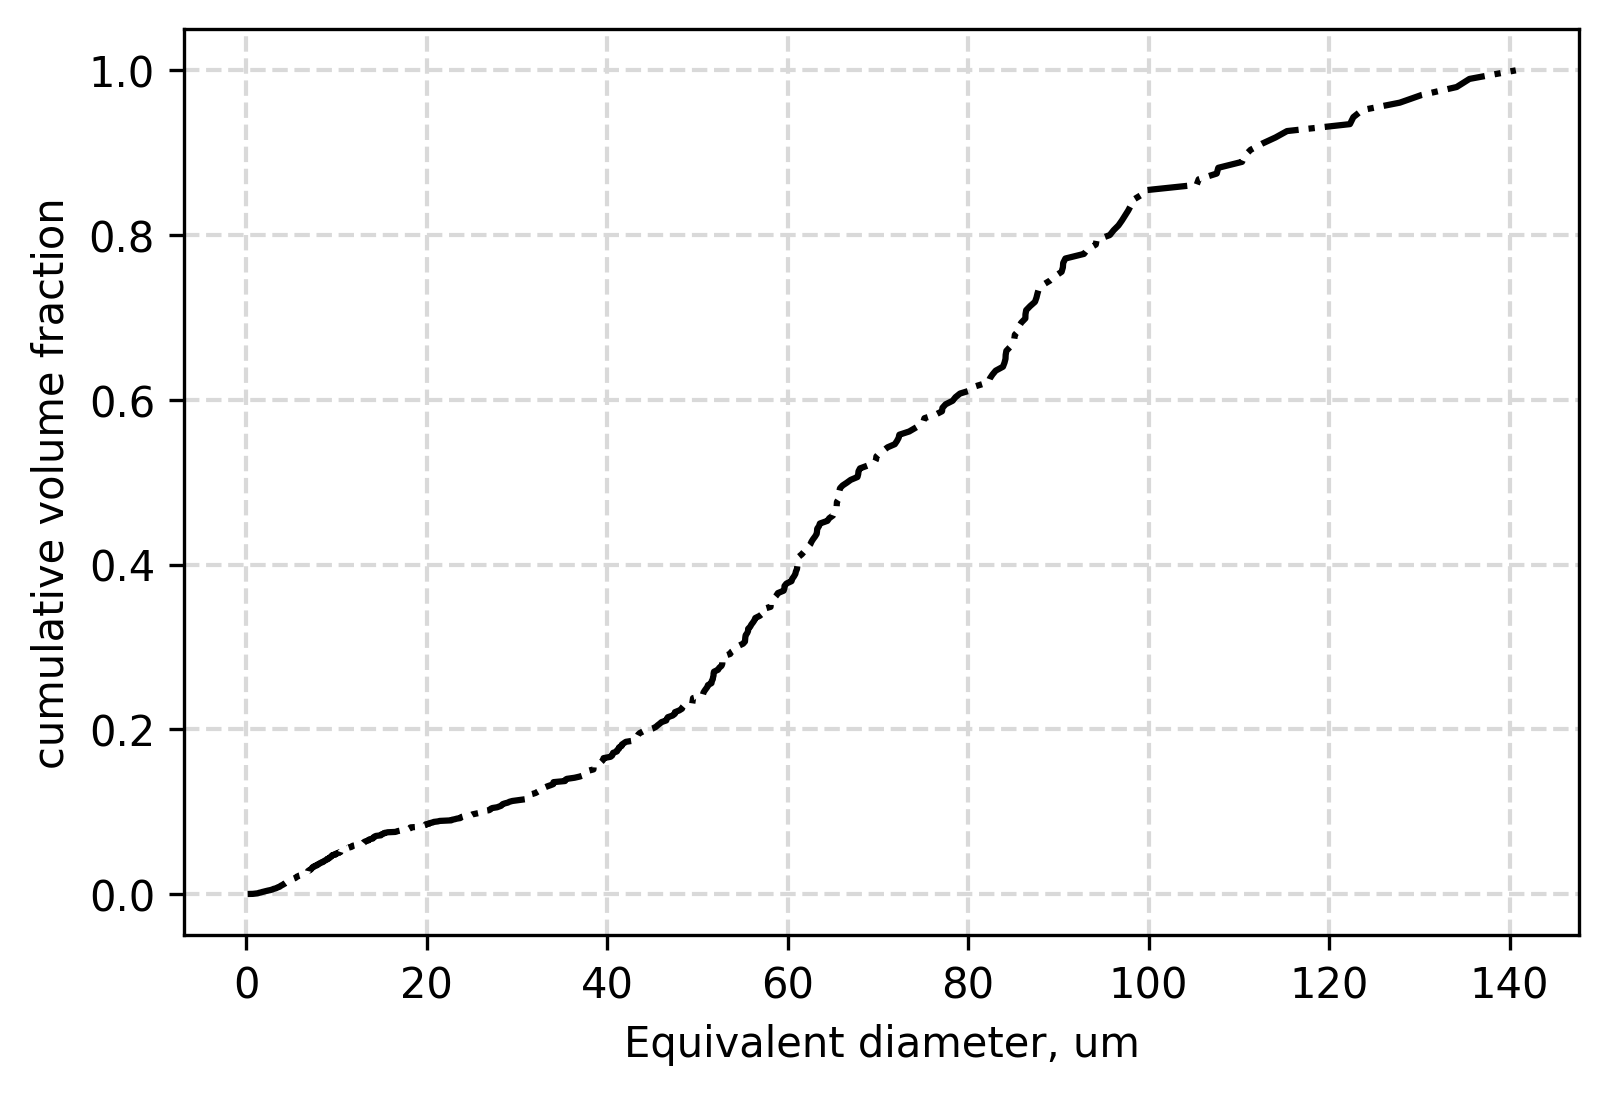

predicted PSD


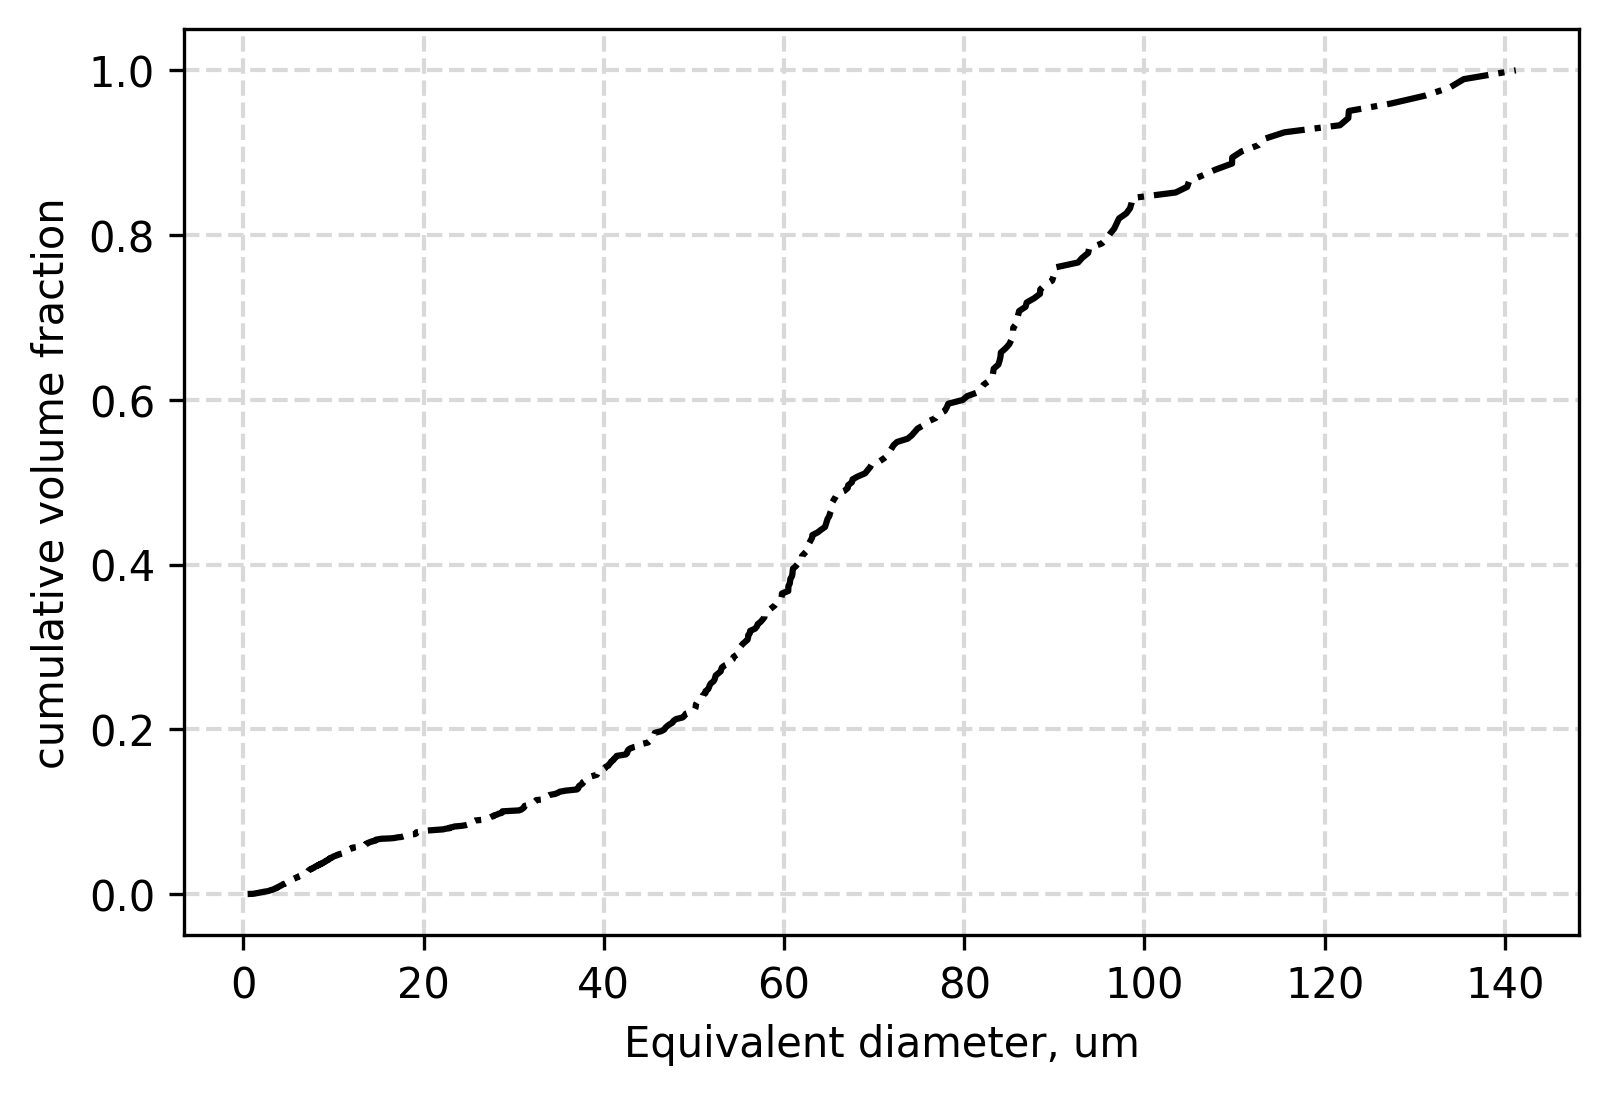

In [17]:
print('ground truth PSD')
areas_gt = powder.psd(iset_particles_gt)
print('predicted PSD')
areas_pred = powder.psd(iset_particles_pred)



# Satellite content measurements
The process here is fairly straightforward. We have masks for powder particles and masks for satellites. To match the satellites to their corresponding particles, we simply overlay the masks and look for intersections. Then, it is trivial to count the number of particles containing satellites. 



We have more labeled satellite images than particle images. We only want to keep images that have labels for both particles and satellites.
To help with the implementation, we can combine the masks for particles and satellites in the PowderSatelliteImage class

In [18]:
iset_particles_gt_ss, iset_satellites_gt_ss = analyze.align_instance_sets(iset_particles_gt, iset_satellites_gt)
iset_particles_pred_ss, iset_satellites_pred_ss = analyze.align_instance_sets(iset_particles_pred, iset_satellites_pred)
psi_gt = []
psi_pred = []
for pg, pp, sg, sp in zip(iset_particles_gt_ss, iset_particles_pred_ss, iset_satellites_gt_ss, iset_satellites_pred_ss):
    files = [Path(x).name for x in [pg.filepath, pp.filepath, sg.filepath, sp.filepath]]
    assert all([x == files[0] for x in files])  # the files are in the same order and there are no excess files
    psi_gt.append(powder.PowderSatelliteImage(particles=pg, satellites=sg))
    psi_pred.append(powder.PowderSatelliteImage(particles=pp, satellites=sp))


In [19]:
for gt, pred in zip(psi_gt, psi_pred):
    for psi in [gt, pred]:
        psi.compute_matches()

The matches for psi are stored in psi.matches as a dictionary. The key 'match_pairs' returns a dictionary whose keys are indices of particle masks that contain satellites. The value corresponding to each key is a list of indices of satellite masks that matched (note that multiple satellites can match with a single particle.)

Text(0.5, 1.0, 'predicted')

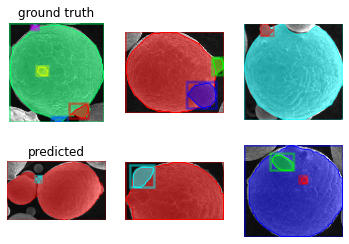

In [20]:
gt = psi_gt[0]
pred = psi_pred[0]

gt_idx = np.random.choice(list(gt.matches['match_pairs'].keys()), 3)
pred_idx = np.random.choice(list(pred.matches['match_pairs'].keys()), 3)

fig, ax = plt.subplots(2,3)


for i, (g, p) in enumerate(zip(gt_idx, pred_idx)):
    gt.visualize_particle_with_satellites(g, ax[0, i])
    pred.visualize_particle_with_satellites(p, ax[1, i])
ax[0,0].set_title('ground truth')
ax[1,0].set_title('predicted')

To compute the ratio of satellited particles, we can get the total number of 

## Final satellite measurements

The number of satellites in each set, fraction of satellited particles, and some other information can be displayed with one command.
The results can be printed directly, and are also returned

In [21]:
print('ground truth results')
results_gt = powder.satellite_measurements(psi_gt, print_summary=True, output_dict=True)
print('predicted results')
results_pred = powder.satellite_measurements(psi_pred, True, True)


ground truth results
number of images                   	5
number of particles                	1360
number of matched satellites       	585
number of unmatched satellites     	2
number of satellited particles     	315
fraction of satellited particles   	0.23161764705882354
median number of satellites per
satellited particle             	1.0
predicted results
number of images                   	5
number of particles                	1138
number of matched satellites       	403
number of unmatched satellites     	20
number of satellited particles     	269
fraction of satellited particles   	0.23637961335676624
median number of satellites per
satellited particle             	1.0


The results are (optionally) returned as a dictionary in case you need to store them for further analysis or post processing.

In [22]:
results_gt

{'n_images': 5,
 'n_particles': 1360,
 'n_satellites': 585,
 'n_satellites_unmatched': 2,
 'n_satellited_particels': 315,
 'sat_frac': 0.23161764705882354,
 'mspp': 1.0,
 'unique_satellites_per_particle': array([ 1,  2,  3,  4,  5,  6,  7, 14]),
 'counts_satellites_per_particle': array([0.53333333, 0.79047619, 0.9047619 , 0.96507937, 0.98095238,
        0.99047619, 0.9968254 , 1.        ])}